# Image Classifier

In [4]:
%load_ext autoreload
%autoreload 2
import cls

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the Data

In [2]:
N=256

#ref = to_img(eh.image.load_fits(ref_path))
ref = np.load('ref.npy')

#ehtims  = load("ehtim",  n=128, ref=ref)
#smilis  = load("smili",  n=128, ref=ref)
#difmaps = load("difmap", n=128, ref=ref)
#imgs    = {**ehtims, **smilis, **difmaps}

imgs    = load("*", n=N*N, ref=ref)
ehtims  = {f:img for f, img in imgs.items() if 'ehtim/'  in f}
smilis  = {f:img for f, img in imgs.items() if 'smili/'  in f}
difmaps = {f:img for f, img in imgs.items() if 'difmap/' in f}

#plot_grid(ehtims.values(), ncol=64)
#plot_grid(smilis.values(), ncol=64)
#plot_grid(difmaps.values(), ncol=64)

# 262,113 fits files in total, while we are sampling 16,384 for now

100%|██████████| 65536/65536 [04:03<00:00, 269.67it/s]


In [ ]:
plot_grid(list(imgs.values())[:128*128], ncol=N)

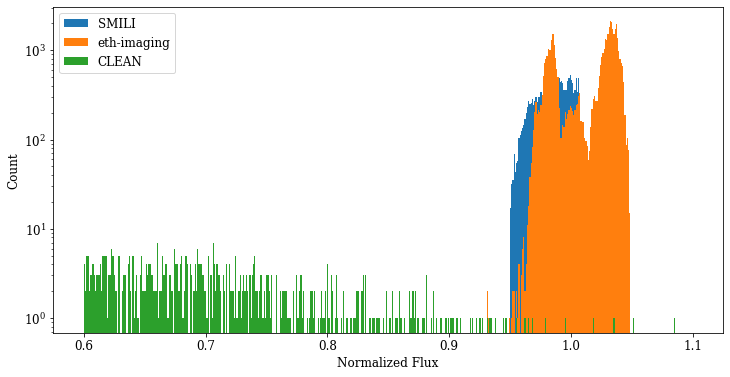

In [5]:
imgs_mean = [np.mean(img) for img in imgs.values()]
imgs_mean_mean = np.mean(imgs_mean)

plt.rcParams["figure.figsize"] = (12,6)
plt.hist([np.mean(img)/imgs_mean_mean for img in smilis.values()],  np.arange(0.6,1.1,0.001), label='SMILI')
plt.hist([np.mean(img)/imgs_mean_mean for img in ehtims.values()],  np.arange(0.6,1.1,0.001), label='eth-imaging')
plt.hist([np.mean(img)/imgs_mean_mean for img in difmaps.values()], np.arange(0.6,1.1,0.001), label='CLEAN')
plt.xlabel('Normalized Flux')
plt.ylabel('Count')
plt.yscale('log')
plt.legend()

## Applying Principal Component Analysis

In [6]:
#top  = 0.5
#vecs = {f:np.minimum(img.flatten()/top, 1.0) for f, img in imgs.items()}

vecs = np.array([img.flatten() for f, img in imgs.items()])
vecs_centered  = vecs - vecs.mean(axis=0)
vecs_centered -= vecs_centered.mean(axis=1).reshape(vecs.shape[0], -1)

pca = PCA().fit(vecs_centered)
#pca = KernelPCA().fit(vecs_centered)
#pca = IncrementalPCA().fit(vecs_centered)
#pca = MiniBatchSparsePCA(alpha=0.8, n_iter=10, batch_size=3).fit(vecs_centered)

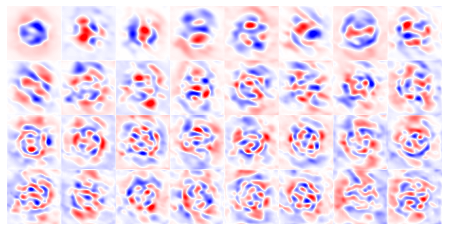

In [8]:
#eigenimgs = pca.components_.reshape((6400,80,80))

eigenimgs = [pca.components_[i,:].reshape(80,80) for i in range(32)]
plot_grid(eigenimgs, ncol=8, vmin=-0.05, vmax=0.05, cmap='bwr')

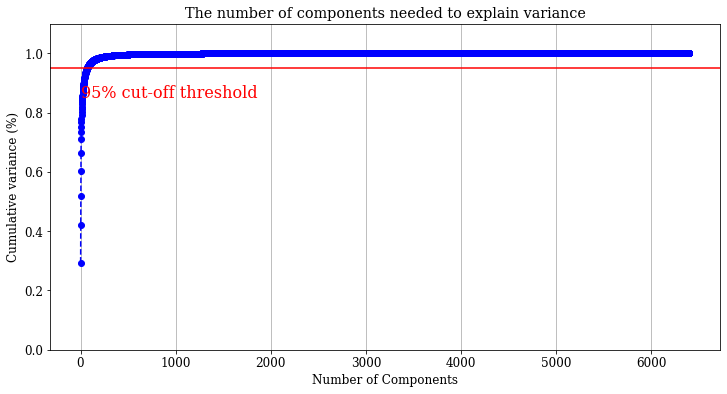

In [9]:
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
y  = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(y)+1, step=1)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')

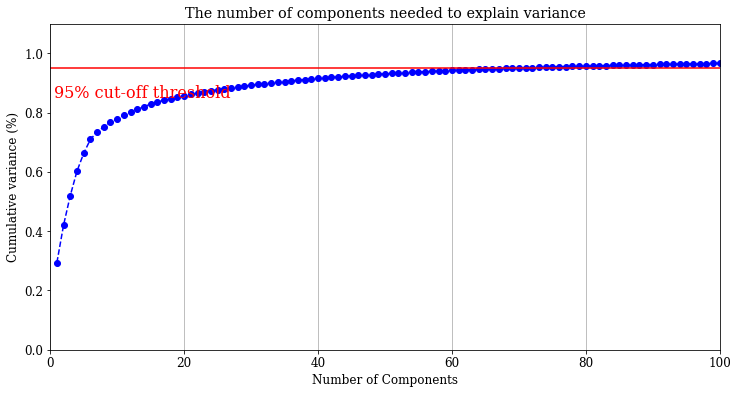

In [10]:
plt.rcParams["figure.figsize"] = (12,6)
fig, ax = plt.subplots()
y  = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(y)+1, step=1)
plt.xlim(0.0,100)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')

In [11]:
# Feature vector after PCA
X_pca = pca.transform(vecs_centered)
print("transformed shape:", X_pca.shape)

transformed shape: (65536, 6400)


In [12]:
n = X_pca.shape[1]
nn = [n]
while n > 50:
    n //= 2
    nn = [n] + nn

Y_pca = X_pca[:,:nn[0]]
for i in range(len(nn)-1):
    print(i, nn[i], nn[i+1])
    subset = X_pca[:,nn[i]:nn[i+1]]
    Y_pca = np.concatenate([Y_pca,
                            np.sum(np.where(subset > 0.0, subset, 0.0), axis=-1)[:,np.newaxis],
                            np.sum(np.where(subset < 0.0, subset, 0.0), axis=-1)[:,np.newaxis]], axis=-1)

print("transformed shape:", Y_pca.shape)

0 50 100
1 100 200
2 200 400
3 400 800
4 800 1600
5 1600 3200
6 3200 6400
transformed shape: (65536, 64)


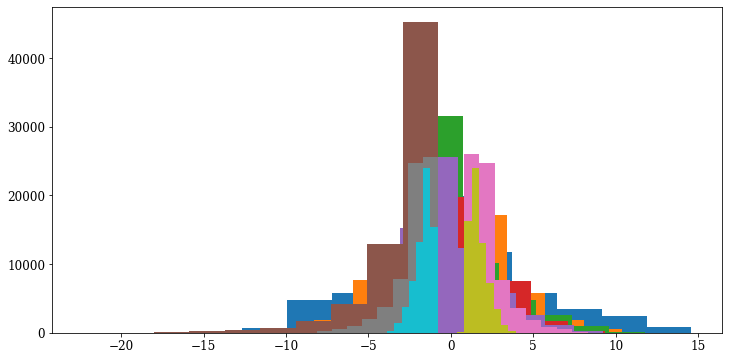

In [13]:
plt.rcParams["figure.figsize"] = (12,6)
for i in list(range(0,5)) + list(range(-5,0)):
    plt.hist(Y_pca[:,i])

## Using the Elbow Method to find the optimal "k" value (number of cluster)

In [ ]:
sum_of_squared_distances = []

K = 32
for k in range(1, K+1):
    km = KMeans(n_clusters=k).fit(Y_pca)
    sum_of_squared_distances.append(km.inertia_)

plt.rcParams["figure.figsize"] = (12,6)
plt.plot(range(1, K+1), sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.xlim(0,K+1)
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

In [ ]:
K = 32

#km = GaussianMixture(n_components=K)
km   = KMeans(n_clusters=K).fit(Y_pca)
kmap = km.predict(Y_pca)

kc   = dict(zip(*np.unique(kmap, return_counts=True)))
keys = list({k: v for k, v in sorted(kc.items(), key=lambda v: v[1], reverse=True)}.keys())

means     = []
variances = []
ivals = list(imgs.values())
for k in keys:
    imgs_k = [ivals[w] for w in np.where(kmap == k)[0]]
    means     += [np.mean(imgs_k, axis=0)]
    variances += [np.var(imgs_k,  axis=0)]
    plot_grid(imgs_k, ncol=32)

In [ ]:
plot_grid(means, ncol=8)
plot_grid(variances, ncol=8, vmax=0.1)

In [27]:
# np.save('ref.npy', means[2])

In [ ]:
tsne_results = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(X_pca)

for k in keys:
    plt.scatter([tsne_results[w,0] for w in np.where(kmap == k)[0]],
                [tsne_results[w,1] for w in np.where(kmap == k)[0]])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16384 samples in 11.052s...
